# PixelCNN for FashionMNIST

### In progress

**The notebook has been adapted from the notebook provided in David Foster's Generative Deep Learning, 2nd Edition.**

- Book: [Amazon](https://www.amazon.com/Generative-Deep-Learning-Teaching-Machines/dp/1098134184/ref=sr_1_1?keywords=generative+deep+learning%2C+2nd+edition&qid=1684708209&sprefix=generative+de%2Caps%2C93&sr=8-1)
- Original notebook (tensorflow and keras): [Github](https://github.com/davidADSP/Generative_Deep_Learning_2nd_Edition/blob/main/notebooks/05_autoregressive/02_pixelcnn/pixelcnn.ipynb)

In [12]:
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets
from torchvision import transforms as Transforms
import torchvision.utils as vuitls

import torchinfo

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

## 0. Train Parameters

In [10]:
IMAGE_SIZE = 16
PIXEL_LEVELS = 12
N_FILTERS = 128
RESIDUAL_BLOCKS = 5
BATCH_SIZE = 128
EPOCHS = 150
LEARNING_RATE = 5e-4

## 1. Preparing FashionMNIST dataset

In [3]:
# Turn input image into (label-pixel representatin, pixel-wise labels)
def collate_fn(batch):
    batch = torch.stack([data[0] for data in batch])
    value_step = 1.0 / PIXEL_LEVELS
    labels = (batch / value_step).type(torch.int)
    imgs = labels.type(torch.float32) * PIXEL_LEVELS
    return imgs, labels

transform_fn = Transforms.Compose([
                    Transforms.ToTensor(),
                    Transforms.Resize(IMAGE_SIZE, antialias=True),                        
                ])

# Load FashionMNIST dataset
fashion_ds = datasets.FashionMNIST('../../data', 
                                  train=True, 
                                  download=True,
                                  transform=transform_fn)

# Get train dataloader
train_loader = DataLoader(fashion_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=collate_fn)

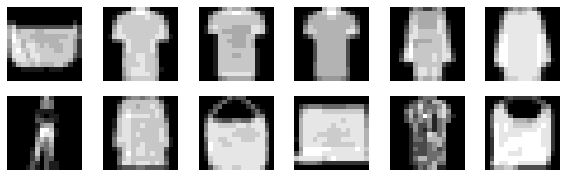

In [4]:
# Check dataset
def plot_imgs(batch, num_rows=2, num_cols=6):
    plt.figure(figsize=(10, 3))
    for i in range(num_rows * num_cols):
        ax = plt.subplot(num_rows, num_cols, i+1)
        ax.imshow(batch[i].permute(1, 2, 0), cmap='gray')
        ax.axis('off')
    plt.show()
        
sample_data = next(iter(train_loader))
plot_imgs(sample_data[0])

## 2. Build the PixelCNN

This PyTorch implementation references pi-tau's GitHub repo: [Link](https://github.com/pi-tau/pixelcnn/blob/master/conv2d_mask.py)

In [5]:
# Building MaskedConv2D layer
class MaskedConv2D(nn.Conv2d):
    
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, **kwargs):
        kwargs['padding'] = 'same'
        super().__init__(in_channels, out_channels, kernel_size, **kwargs)

        assert mask_type in ['A', 'B'], 'Mask type should be either A or B'
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)

        # Creating masks
        kh, kw = kernel_size
        mask = torch.ones_like(self.weight)
        mask[:, :, (kh // 2 + 1):, :] = 0
        mask[:, :, (kh // 2), (kw // 2 + 1):] = 0
        # If mask type is A, then masking the center pixel
        if mask_type == 'A':
            mask[:, :, (kh // 2), (kw // 2)] = 0

        # Making the mask the non-trainable parameter of the module
        self.register_buffer('mask', mask.type(dtype=torch.bool))

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, self.bias, 
                        self.stride, self.padding)

In [6]:
# Check the mask in the masked conv layer
print("Type \"A\" mask of the conv layer:")
print(MaskedConv2D('A', 1, 1, 5).mask.numpy())

print("\nType \"B\" mask of the conv layer:")
print(MaskedConv2D('B', 1, 1, 5).mask.numpy())

Type "A" mask of the conv layer:
[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True False False False]
   [False False False False False]
   [False False False False False]]]]

Type "B" mask of the conv layer:
[[[[ True  True  True  True  True]
   [ True  True  True  True  True]
   [ True  True  True False False]
   [False False False False False]
   [False False False False False]]]]


In [7]:
# Building the residual block
class ResidualBlock(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv_1 = nn.Sequential(
                        nn.Conv2d(in_channels=in_channels, 
                                  out_channels=out_channels // 2,
                                  kernel_size=1, padding='valid',
                                  stride=1),
                        nn.ReLU())

        self.pixel_conv = nn.Sequential(
                        MaskedConv2D(
                            mask_type='B',
                            in_channels=out_channels // 2,
                            out_channels=out_channels // 2,
                            kernel_size=3,
                            padding='same'),
                        nn.ReLU())

        self.conv_2 = nn.Sequential(
                        nn.Conv2d(in_channels=out_channels // 2,
                                  out_channels=out_channels,
                                  kernel_size=1,
                                  padding='valid'),
                        nn.ReLU())

    
    def forward(self, x):
        conv_x = self.conv_1(x)
        conv_x = self.pixel_conv(conv_x)
        conv_x = self.conv_2(conv_x)
        return x + conv_x        

In [8]:
# Check the residual block
# model = ResidualBlock(4, 4)
# torchinfo.summary(model=model, input_size=(1, 4, 32, 32))

In [9]:
class PixelCNN(nn.Module):

    def __init__(self, num_filters, num_res_blocks, ouput_size=PIXEL_LEVELS):
        super().__init__()
        self.masked_conv_1 = nn.Sequential( 
                                MaskedConv2D(
                                    mask_type='A',
                                    in_channels=1,
                                    out_channels=num_filters,
                                    kernel_size=7,
                                    padding='same'),
                                nn.ReLU()
                             )

        self.res_convs = nn.Sequential(*[
                            ResidualBlock(
                                in_channels=num_filters,
                                out_channels=num_filters)
                            for _ in range(num_res_blocks)])

        self.masked_conv_2 = nn.Sequential(*[
                                nn.Sequential(
                                    MaskedConv2D(
                                        mask_type='B',
                                        in_channels=num_filters,
                                        out_channels=num_filters,
                                        kernel_size=1,
                                        padding='valid'),
                                    nn.ReLU())
                                for _ in range(2)],
                            )

        self.output_conv = nn.Conv2d(in_channels=num_filters,
                                     out_channels=ouput_size,
                                     kernel_size=1,
                                     stride=1,
                                     padding='valid')
        # We don't need a softmax layer when using CrossEntropy Loss in PyTorch

    def forward(self, x):
        x = self.masked_conv_1(x)
        x = self.res_convs(x)
        x = self.masked_conv_2(x)
        x = self.output_conv(x)
        return x

model = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS)
torchinfo.summary(model=model, input_size=(1, 1, IMAGE_SIZE, IMAGE_SIZE))

Layer (type:depth-idx)                   Output Shape              Param #
PixelCNN                                 [1, 12, 16, 16]           --
├─Sequential: 1-1                        [1, 128, 16, 16]          --
│    └─MaskedConv2D: 2-1                 [1, 128, 16, 16]          6,400
│    └─ReLU: 2-2                         [1, 128, 16, 16]          --
├─Sequential: 1-2                        [1, 128, 16, 16]          --
│    └─ResidualBlock: 2-3                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-1              [1, 64, 16, 16]           8,256
│    │    └─Sequential: 3-2              [1, 64, 16, 16]           36,928
│    │    └─Sequential: 3-3              [1, 128, 16, 16]          8,320
│    └─ResidualBlock: 2-4                [1, 128, 16, 16]          --
│    │    └─Sequential: 3-4              [1, 64, 16, 16]           8,256
│    │    └─Sequential: 3-5              [1, 64, 16, 16]           36,928
│    │    └─Sequential: 3-6              [1, 128, 16, 16]        

## 3. Define the model, objective, and optimizer

In [14]:
pixel_cnn = PixelCNN(N_FILTERS, RESIDUAL_BLOCKS).to(DEVICE)

if torch.__version__.split('.')[0] == '2':
    torch.set_float32_matmul_precision('high')
    # It is important to use eager backend here to avoid
    # distribution mismatch in training and predicting
    pixel_cnn = torch.compile(pixel_cnn, backend='eager')
    print('model compiled')

optim = torch.optim.Adam(pixel_cnn.parameters(), lr=LEARNING_RATE)

model compiled
